# Load Libraries

In [55]:
import logging
import locale
import functools
import glob
import pathlib
import io

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy.optimize import curve_fit, broyden1
import requests

import warnings
warnings.filterwarnings("ignore")

locale.setlocale(locale.LC_ALL, 'de_DE')

xticks = ["03-01", "03-15", "04-01", "04-15", "05-01", "05-15", "06-01"]

# Download Data

In [2]:
# Read "Our world in data" (Lacks sublocations) (Use only one of IHME + convert or this cell)
dWorld = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
dWorld["wrkDate"]=pd.to_datetime(dWorld.date)

# Filter Deutschland

In [79]:
germany = dWorld[dWorld.location == "Germany"]
germany.set_index(["wrkDate"], inplace=True)

# Tägliche Fallzahlen

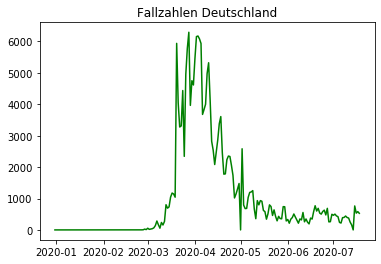

In [96]:
plt.title("Fallzahlen Deutschland")
plt.plot(germany.new_cases, "green")

# Kummulierte Fallzahlen

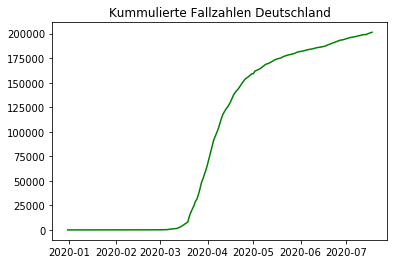

In [95]:
germany["cum"] = germany.new_cases.cumsum()
plt.title("Kummulierte Fallzahlen Deutschland")
plt.plot(germany.cum, "green")

# 7 Tage geglättet
Dazu wird der Schnitt der **vorhergehenden** 7 Tage genutzt
Dmit wird der Wocheneffekt (Öffnungszeiten Gesundheitsämter und Arztpraxen, Feiertage) ausgeglichen

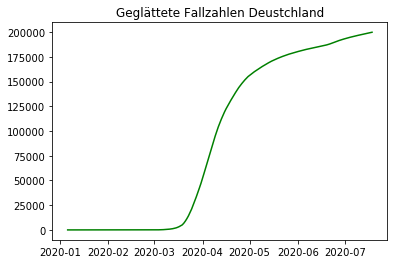

In [104]:
germany["smooth"] = germany.cum.rolling(7).mean()

plt.title("Geglättete Fallzahlen Deustchland")
plt.plot(germany.smooth, "green")

# Mit logarithmischer Y Achse

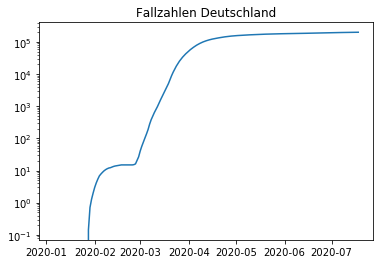

In [105]:
plt.title("Fallzahlen Deutschland")
plt.yscale("log")
plt.plot(germany.smooth)

Wir sehen 2 Ausbrüche:
* Den 1. Ausbruch bei Webasto im Januar
* Den 2. Ausbruch im März

# Wir betrachten nun den 2. Ausbruch (und nicht den ersten  im Januar)

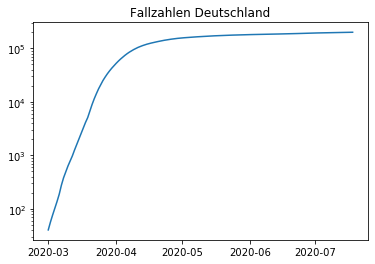

In [106]:
wrk = germany[germany.date > "2020-02-29"].copy()

plt.title("Fallzahlen Deutschland")
plt.yscale("log")
plt.plot(wrk.smooth)

# Steigung der logarithmischen Kurve

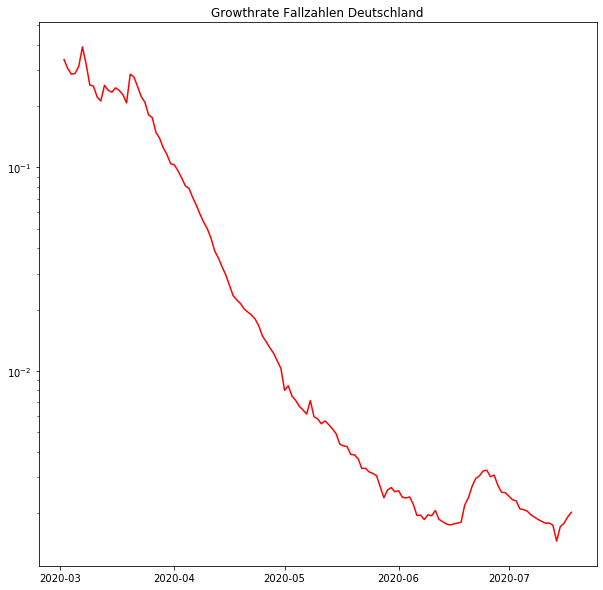

In [107]:
wrk["diffG"] = np.log(wrk.smooth).diff()
plt.figure(figsize=(10,10))
plt.title("Growthrate Fallzahlen Deutschland")
plt.yscale("log")
plt.plot(wrk.diffG, "r")

Aus der Kurve kann die geglättete Ursprungskurve rekonstruiert werden (wenn man den Startpunkt kennt)

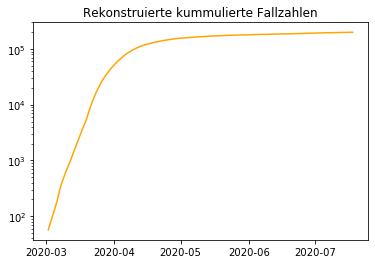

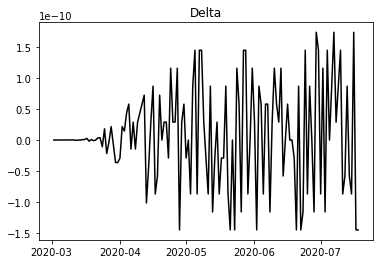

In [99]:
start = np.log(wrk.iloc[0].smooth)

wrk["reconstructed"] =  np.exp(start + wrk.diffG.cumsum())
plt.title("Rekonstruierte kummulierte Fallzahlen")
plt.yscale("log")
plt.plot(wrk.reconstructed, "orange")
plt.show()
plt.title("Delta")
plt.plot(wrk.reconstructed - wrk.smooth, color="black")

Man beachte die Skala der schwarzen Kurve (1e -10). Die rekonstruiereten Werte sind also praktisch gleich den Ursprungswerten

# Mathematische Eigenschaften
* Jeder Punkt aif den Kurven hängt nur von Daten ab, die zeitlich an den Datum waren oder davor (also links davon).
* Ein exponentieller Anstieg wäre eine nach oben zeigende Grerade in der blauen logrithmischen Kurve
* Aus der roten Kurve kann man exponentieren und integrieren wieder zu blauen Kurve gelangen (wenn man den Startpunkt kennt)
* Aus der blauen Kurve kann man durch differenzieren wieder zu geglätteten täglichen Fallzahlen kommen.
* Diese Aussagen sind völlig unabhängig von irgendeinem Verlaufsmodell.
* Die rote Kurve reagiert auf jede Änderung der Fallzahlen

# Was sehen wir?
* Die blaue Kurve ist keine nach oben gerichtete Gerade sondern sie ist eine immer flacher werdende Kurve. Es gibt also niemals einen exponetiellen Anstieg.
* Die rote Kurve fällt sehr bald (um den 20.03.) praktisch in einer Geraden ab die dann flacher wid und Mitte Juni in Schwingungen um die Horizontale abknickt)
* Dies gilt in den meisten grösseren Staaten (ausser den USA, dort muss man die Bundesstaaten betrachten).

# Was schliesse ich daraus
* Wenn die Einführung oder Aufhebung einer Massnahme (zB Lockdown am 23.03., Einführung Maskenpflich am 28.04.) irgendeine Wirkung hätte, müsste dies den Verlauf der blauen Kurve
einige Tage nach der Einführung(Inkubationszeit plus Zeit für Test) ändern
* Dies würde auch zu einer Änderung der roten Kurve führen die sehr sensibel auf dauerhafte Veränderungen reagiert.
* Da die rote Kurve aber einige Tage nach den Massnahmen unverändert dem vorherigen Trend folgt sind die Massnahmen praktisch wirkungslos gewesen.
* Ansonsten hätte ja ohne die Massnahmen ein Knick der roten Kurve ein paar Tage nach der Massnahme da sein müssen. Aber wieso gearde dann und nicht irgendwann anders.

Ähnliche Analysen kann man nicht nur mit den Fallzahlen sondern auch mt den Todeszahlen machen. Dort ist die rote Kurve noch viel gleichmässiger, da dort die externen Einflussmöglichkeiten 
durch Testzahl und Teststrategie nicht bestehen.

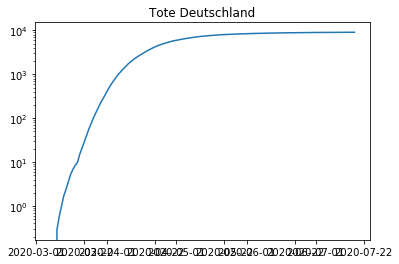

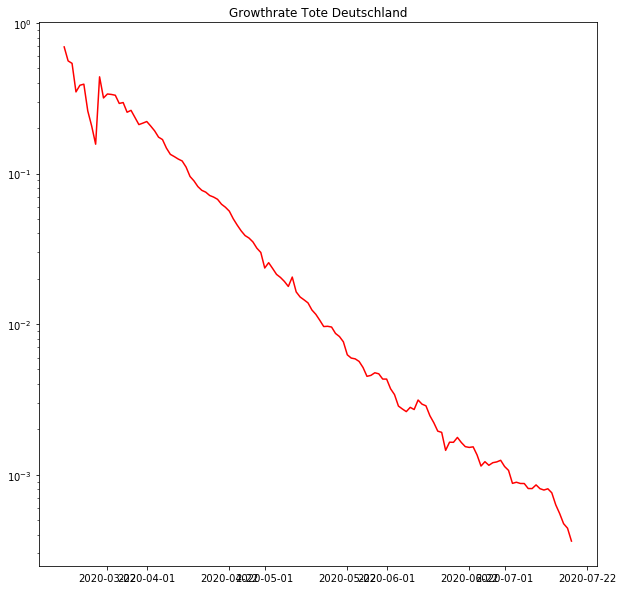

In [88]:
wrk["cumDeath"] = wrk.new_deaths.cumsum()
wrk["smoothDeath"] = wrk.cumDeath.rolling(7).mean()
plt.title("Tote Deutschland")
plt.yscale("log")
plt.plot(wrk.smoothDeath)
plt.show()
wrk["diffGDeath"] = np.log(wrk.smoothDeath).diff()
plt.figure(figsize=(10, 10))
plt.title("Growthrate Tote Deutschland")
plt.yscale("log")
plt.plot(wrk.diffGDeath, "r")

Die gleiche Analyse kann man in vielen Ländern bei der Einführung oder Aufhebung von Massnahmen durchführen).

Man kann also ohne jede virologische oder epidemologischen Kennisse alleine auf Basis der Zahlen die praktische Wirkungslosigkeit fer Massnahmen beweisen.